# Distribution analysis of clusters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
# from vae import VAE
from dataloader import UTKFaceDataset
import seaborn as sns
import pandas as pd
from ae import AutoEncoderNet
from torchvision.utils import make_grid
from sklearn import metrics
from sklearn.cluster import KMeans
from matplotlib import gridspec
from sklearn import metrics


## Model and data

In [12]:
BATCH_SIZE = 64
DEVICE = "cpu"

dataset = UTKFaceDataset(data_type="test", gray_scale=False)
# test_loader = torch.utils.data.DataLoader(dataset,batch_size= BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# model_path = "models/AutoEncoder_256.pt"
# model = AutoEncoderNet(n_channels=3, dim_last_layer=(64, 21, 21), latent_features=256)
# model.load_state_dict(torch.load(model_path))
# model.to(DEVICE)
# model.eval()

z = np.load("Z.npy")
y = np.load("Y.npy")
assert (y-dataset.y).sum().sum() == 0
x = dataset.X


## K-means clustering

In [24]:
kmeans = KMeans(n_clusters=24, random_state = 42)
labels = kmeans.fit_predict(z)
df = pd.DataFrame({"age":y[:,0], "gender" : y[:,1], "race" : y[:,2], "cluster":labels})
display(df)

,age,gender,race,cluster
0,35,1,2,4
1,26,0,0,6
2,90,0,0,1
3,28,0,1,5
4,60,1,1,5
...,...,...,...,...
4736,40,0,0,7
4737,27,0,0,16
4738,16,0,0,20
4739,50,0,2,4


## Age distribution

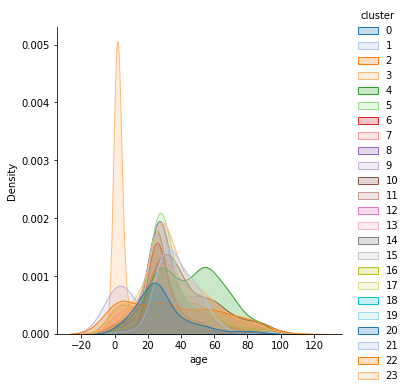

In [29]:
sns.displot(df, x ="age",hue="cluster",kind="kde", fill=True,palette=sns.color_palette("tab20",24))

## Gender distribution

## Race distribution